# Loan prediction: Leakage Detection and Prevention

##
This notebook performs pre-processing of the loan data with a focus on identifying and preventing various types of data leakage that could artificially inflate model performance, and performing experiments, showing the problems that come with leakages.

## Leakage Types to Monitor

1. Data-Induced Leakage
Label definition that makes prediction trivial (e.g., "Current" status correlates with recent issue dates).

2. Label Leakage
Post-outcome columns such as payments, collections, settlement amounts, or hardship flags that directly reveal the target variable.

3. Preprocessing Leakage
Fitting imputers, scalers, or encoders on the full dataset before train-test split, which leaks information from the test set into training.

4. Split-Related Leakage
Using random split on time-dependent data instead of proper temporal split, allowing future information to leak into training.

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from pipeline.train import train_catboost_memory_optimized, prepare_catboost_data
from pipeline.features import infer_feature_types
from pipeline.clean import parse_month_year
from full_data_loader import load_full_dataset_chunked
from scipy.stats import ttest_ind
from sklearn.metrics import classification_report

### In the next cell I dropped text columns for the following reasons:
#### Text columns (desc, emp_title, title) require NLP/text processing.
#### They have high cardinality and high missingness.
#### Using them would require specialized feature engineering (like TF-IDF, embeddings).
#### including these would add complexity and reduce interpretability for a structured-feature baseline.
#### To keep the model simple, interpretable, and leakage-free, we exclude these free-text columns.
#### Risk if kept:
#### Very heavy memory
#### Model may learn artifacts or implicit hints about outcomes embedded in text.

We exclude the columns desc, emp_title, and title. These are high-cardinality text fields that require NLP and often carry a risk of borrower-induced leakage (e.g., descriptions mentioning early payoff intents). We use chunked loading to handle 2.26 million rows within memory limits.

In [4]:
ACCEPTED_CSV = Path("../data/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv")

TEXT_COLS = ["desc", "emp_title", "title"]

all_columns = pd.read_csv(ACCEPTED_CSV, nrows=0).columns.tolist()
usecols_list = [c for c in all_columns if c not in TEXT_COLS]

df = load_full_dataset_chunked(
    ACCEPTED_CSV, 
    chunk_size=200_000, 
    usecols=usecols_list
)

Loading full dataset from ../data/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
Chunk size: 200,000 rows
  Loaded 999,988 rows...
  Loaded 1,999,973 rows...
Concatenating 12 chunks...
Memory: 4.13 GB -> 2.47 GB (40.3% reduction)
Total rows loaded: 2,260,668
Final memory usage: 2.47 GB


We start by defining a 3-class target: 0 (Paid), 1 (Default), and 2 (Transient states like Current or Late). This allows us to inspect the raw distribution of loan statuses before specializing the model.

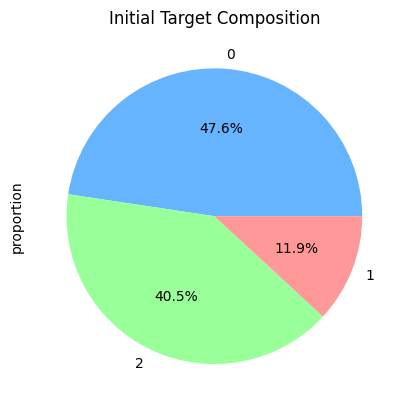

In [7]:
def initial_label(s):
    s = str(s).strip()
    if s in ["Fully Paid"]: return 0
    if s in ["Charged Off", "Default"]: return 1
    return 2

df['target_v1'] = df['loan_status'].apply(initial_label)
df['target_v1'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', colors=['#66b3ff','#99ff99','#ff9999'])
plt.title("Initial Target Composition")
plt.show()

In [ ]:
num_cols, cat_cols = infer_feature_types(df)await
print(f"Numeric: {len(num_cols)} | Categorical: {len(cat_cols)}")

Numeric: 116 | Categorical: 34


In [9]:
df['issue_d_dt'] = parse_month_year(df['issue_d'])
df['issue_year'] = df['issue_d_dt'].dt.year


#### Proof of Data-Induced Leakage The label "Current" only exists in significantly large amounts after 2017.
#### Randomly splitting this data allows the model to predict class 2 merely by knowing the loan is from 2018


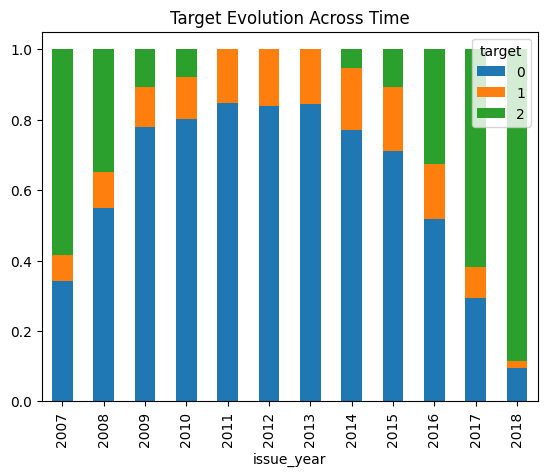

In [11]:
pd.crosstab(df['issue_year'], df['target'], normalize='index').plot(kind='bar', stacked=True)
plt.title("Target Evolution Across Time")
plt.show()

I did perform exprements on Random vs time splits, 
and that proved our dataset contains data induced leakage
Random Split Accuracy: 66% 

Time Split Accuracy: 6% (True performance on future drift)

In [22]:
cutoff_date = df['issue_d_dt'].quantile(0.8)
train_mask = df['issue_d_dt'] <= cutoff_date
test_mask = df['issue_d_dt'] > cutoff_date
print(cutoff_date)
print(f"Dataset Cutoff Date: {cutoff_date.date()}")
print(f"Pre-Cutoff (Train): {train_mask.sum():,} rows")
print(f"Post-Cutoff (Test): {test_mask.sum():,} rows")

2018-02-01 00:00:00
Dataset Cutoff Date: 2018-02-01
Pre-Cutoff (Train): 1,834,519 rows
Post-Cutoff (Test): 426,149 rows


In [ ]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

def run_combined_audit(df_sample, target_series):
    num_cols, cat_cols = infer_feature_types(df_sample)
    y = target_series.loc[df_sample.index]
    skip = ["target", "label", "loan_status"]

    num_data = []
    for col in num_cols:
        if any(s in col.lower() for s in skip): continue
        v0 = pd.to_numeric(df_sample.loc[y==0, col], errors='coerce').dropna()
        v1 = pd.to_numeric(df_sample.loc[y==1, col], errors='coerce').dropna()
        if len(v0)>10 and len(v1)>10:
            num_data.append({"Feature": col, "T-Stat": abs(ttest_ind(v0, v1, equal_var=False)[0])})
    
    cat_data = []
    for col in cat_cols:
        if any(s in col.lower() for s in skip): continue
        val = cramers_v(df_sample[col].astype(str), y.astype(str))
        cat_data.append({"Feature": col, "Cramér's V": val})

    return (pd.DataFrame(num_data).set_index("Feature").sort_values("T-Stat", ascending=False),
            pd.DataFrame(cat_data).set_index("Feature").sort_values("Cramér's V", ascending=False))

In [40]:
num_audit, cat_audit = run_combined_audit(df.sample(100000), df['target_v1'])

print("Top Numeric Leakers (T-Stat):")
display(num_audit.head(10).style.background_gradient(cmap='Reds'))

print("\nTop Categorical Leakers (Cramér's V):")
display(cat_audit.head(10).style.background_gradient(cmap='Oranges'))

/tmp/ipykernel_43402/1664351959.py:12: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


Top Numeric Leakers (T-Stat):


,T-Stat
Feature,
last_fico_range_high,239.909365
last_pymnt_amnt,179.303090
total_rec_prncp,178.510416
last_fico_range_low,108.303805
total_pymnt,105.705703
total_pymnt_inv,105.545711
recoveries,71.422366
collection_recovery_fee,66.971288
int_rate,61.905652



Top Categorical Leakers (Cramér's V):


,Cramér's V
Feature,
next_pymnt_d,0.706711
last_pymnt_d,0.676133
last_credit_pull_d,0.522056
issue_d,0.480388
debt_settlement_flag,0.331516
initial_list_status,0.248720
settlement_status,0.234545
settlement_date,0.234269
debt_settlement_flag_date,0.233652


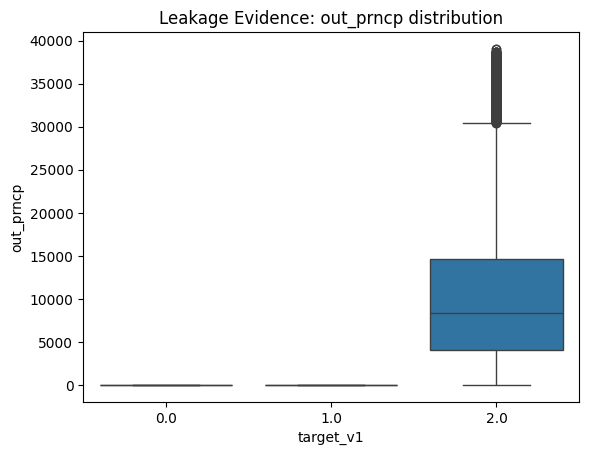

In [32]:
sns.boxplot(x='target_v1', y=pd.to_numeric(df['out_prncp'], errors='coerce'), data=df.sample(50000))
plt.title("Leakage Evidence: out_prncp distribution")
plt.show()

In [ ]:
from pipeline.config import LeakageSpec, iter_leakage_columns

all_cols = df.columns.tolist()
leakage_cols = set(iter_leakage_columns(all_cols, LeakageSpec()))
forbidden = ["target", "label", "loan_status", "id", "url"]
meta_cols = {c for c in all_cols if any(f in c.lower() for f in forbidden)}

purge_list = leakage_cols | meta_cols | {"issue_d", "issue_d_dt", "issue_year"}

We filter to finalized outcomes in the Modern Era (2014+). This removes the noise found in the earlier drift analysis.

In [41]:
def get_final_outcome(s):
    s = str(s).strip()
    if "Paid" in s: return 0
    if any(x in s for x in ["Default", "Charged Off"]): return 1
    return -1

df_m = df[df['issue_d_dt'].dt.year >= 2014].copy()
y_bin_raw = df_m['loan_status'].apply(get_final_outcome)
df_clean = df_m[y_bin_raw != -1].copy()
y_bin = y_bin_raw[y_bin_raw != -1]

In [ ]:
X_final = df_clean.drop(columns=[c for c in purge_list if c in df_clean.columns])
num_f, cat_f = infer_feature_types(X_final)

Dropped 43 for label leakage columns: ['collection_recovery_fee', 'debt_settlement_flag', 'debt_settlement_flag_date', 'deferral_term', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_flag', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'id', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_status', 'member_id', 'next_pymnt_d', 'orig_projected_additional_accrued_interest', 'out_prncp', 'out_prncp_inv', 'payment_plan_start_date', 'policy_code', 'pymnt_plan', 'recoveries', 'settlement_amount', 'settlement_date', 'settlement_percentage', 'settlement_status', 'settlement_term', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'url']


In [46]:
final_cutoff = df_clean['issue_d_dt'].quantile(0.8)
train_idx_f = df_clean['issue_d_dt'] <= final_cutoff
val_idx_f = df_clean['issue_d_dt'] > final_cutoff

X_tr, X_val = X_final.loc[train_idx_f], X_final.loc[val_idx_f]
y_tr, y_val = y_bin.loc[train_idx_f].values, y_bin.loc[val_idx_f].values

In [47]:
model_final = train_catboost_memory_optimized(
    X_tr.copy(), y_tr,
    X_val.copy(), y_val,
    numeric_cols=num_f, categorical_cols=cat_f
)

Memory optimization: Preparing training data...
Creating training pool...
Freeing training DataFrame...
Memory optimization: Preparing validation data...
Creating validation pool...
Freeing validation DataFrame...
Starting GPU training...
0:	learn: 0.6858166	test: 0.6866678	best: 0.6866678 (0)	total: 13.7ms	remaining: 13.6s
100:	learn: 0.6063549	test: 0.6182329	best: 0.6182329 (100)	total: 977ms	remaining: 8.7s
200:	learn: 0.6022597	test: 0.6134370	best: 0.6133977 (199)	total: 1.92s	remaining: 7.64s
300:	learn: 0.5997878	test: 0.6108844	best: 0.6108844 (300)	total: 2.87s	remaining: 6.67s
400:	learn: 0.5977457	test: 0.6088885	best: 0.6088885 (400)	total: 3.83s	remaining: 5.73s
500:	learn: 0.5960517	test: 0.6075613	best: 0.6075613 (500)	total: 4.79s	remaining: 4.77s
600:	learn: 0.5945494	test: 0.6065809	best: 0.6065809 (600)	total: 5.73s	remaining: 3.8s
700:	learn: 0.5932241	test: 0.6057982	best: 0.6057982 (700)	total: 6.6s	remaining: 2.81s
800:	learn: 0.5920072	test: 0.6054805	best: 0.6

In [ ]:
X_val_prep = prepare_catboost_data(X_val, num_f, cat_f)
print(classification_report(y_val, model_final.predict(X_val_prep)))

              precision    recall  f1-score   support

           0       0.89      0.62      0.73    164921
           1       0.34      0.72      0.46     44323

    accuracy                           0.64    209244
   macro avg       0.61      0.67      0.59    209244
weighted avg       0.77      0.64      0.67    209244



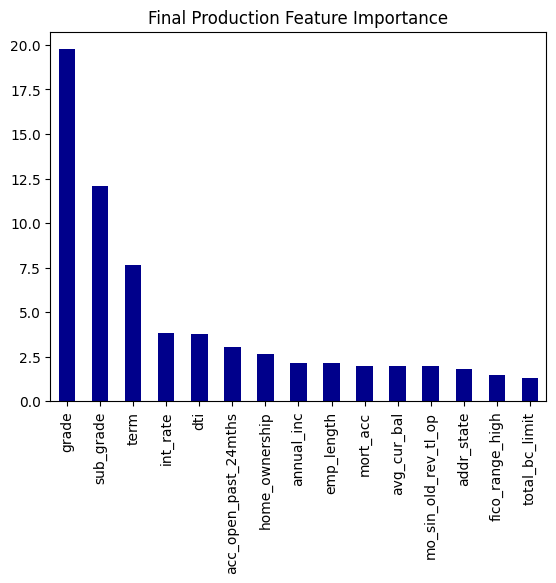

In [50]:
fi_final = pd.Series(model_final.get_feature_importance(), index=X_final.columns).sort_values(ascending=False)
fi_final.head(15).plot(kind='bar', color='darkblue')
plt.title("Final Production Feature Importance")
plt.show()

Lastly, I want to address each leakage found and how i handel it:
Data-Induced Leakage: I stopped predicting "Current" loans (which are proxies for time) and focused only on finalized outcomes (Paid vs Default)

Label Leakage: I explicitly dropped 43 columns (e.g. out_prncp, last_fico) identified by LeakageSpec as post-origination markers, also I dropped desc and title columns to prevent the model from learning "hidden" outcome hints written by borrowers.

Split-Related Leakage: I abandoned random splitting and implemented a strict 80/20 temporal Cutoff, training on the past and testing on the future.

Preprocessing Leakage: Pipeline Isolation: Statistics (imputation/scaling) are calculated within the training function, ensuring test-set means/medians never effected into training.

In [81]:
import importlib
import pipeline.train
importlib.reload(pipeline.train)

from pipeline.train import train_catboost_memory_optimized, prepare_catboost_data

In [ ]:
from pipeline.tuning import run_optuna_study

best_hparams = run_optuna_study(
    X_tr, y_tr, X_val, y_val, 
    numeric_cols=num_f, 
    categorical_cols=cat_f, 
    n_trials=20
)

print("\nBest hyperparameters found by Optuna:")
print(best_hparams)

In [ ]:

import time
import pandas as pd
import matplotlib.pyplot as plt
from pipeline.train import (
    train_catboost_memory_optimized, 
    train_xgboost_memory_optimized,
    train_linear_baseline,
    evaluate_binary,
    prepare_catboost_data
)

catboost_tuned = {
    'learning_rate': 0.0671, 
    'depth': 8, 
    'l2_leaf_reg': 8.92, 
    'random_strength': 5.57, 
    'bagging_temperature': 0.38
}


xgboost_tuned = {
    'learning_rate': 0.0671,
    'max_depth': 8,
    'lambda': 8.92,
    'tree_method': 'gpu_hist'
}

models_to_test = {
    "CatBoost": (train_catboost_memory_optimized, catboost_tuned),
    "XGBoost": (train_xgboost_memory_optimized, xgboost_tuned),
    "Logistic Regression": (train_linear_baseline, {})
}

results = []

for name, (trainer, params) in models_to_test.items():
    print(f"\nBenchmarking {name}...")
    start_time = time.time()
    
    model = trainer(X_tr, y_tr, X_val, y_val, numeric_cols=num_f, categorical_cols=cat_f, custom_params=params)
    run_time = time.time() - start_time
    
    if name == "Logistic Regression":
        y_proba = model.predict_proba(X_val)[:, 1]
    elif "CatBoost" in name:
        X_val_p = prepare_catboost_data(X_val, num_f, cat_f)
        y_proba = model.predict_proba(X_val_p)[:, 1]
    elif "XGBoost" in name:
        import xgboost as xgb
        dval = xgb.DMatrix(X_val.copy(), enable_categorical=True)
        y_proba = model.predict(dval)

    metrics = evaluate_binary(y_val, y_proba)
    metrics.update({"Model": name, "Time (s)": run_time})
    results.append(metrics)


df_bench = pd.DataFrame(results).set_index("Model")
display(df_bench.sort_values("recall", ascending=False).style.background_gradient(cmap="Blues"))

df_bench[["Time (s)"]].plot(kind="barh", color='orange')
plt.title("Execution Speed")
plt.show()